## Project 1 : Query Project

The goal of this project was to determine potential marketing offers that could increase ridership for Lyft Bay Wheels in the San Francisco Bay Area. By analyzing the `san_francisco` public SQL dataset containing ridership data on Lyft Bay Wheels hosted on Google BigQuery, the aim was to detect any trends or gaps that could be leveraged towards developing new offers or tailoring existing ones to attract more customers. 

The following tables from the `san_francisco` dataset were used in the analysis:
- bikeshare_stations
- bikeshare_status
- bikeshare_trips

*Note: Code for all intermediary views that were created and used in the SQL queries are included in the Appendix*

In [3]:
# Matplotlib will be used for data visualizations
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### What are the 5 most popular trips that you would call "commuter trips"?

Through the analysis, it was determined that "commuter trips" make up a significant portion of the ridership in the Bay Area, and as a result the data around these types of trips was analyzed for trends, patterns, and gaps. "Commuter trips" are trips that satisfy the following condtions:
1. The trip occurs during the week (Monday, Tuesday, Wednesday, Thursday, or Friday)
2. The start of the trip takes place during "commuting hours", which are defined as between 7:00-9:59 and 16:00-18:59 PST
3. The station from which the trip starts and the station at which the trip ends are not the same

In the cell below, the bigquery magic command is used to fetch data from a previously created `commuter_trips` view and store it into a dataframe. The `commuter_trips` view stores details of all trips within the `bikeshare_trips` table that meet the first two conditions above.

In [1]:
%%bigquery df_commuter_trips

SELECT start_station_name, end_station_name, COUNT(trip_id) AS num_trips,
FROM `w205-project-300900.bike_trip_data.commuter_trips`
WHERE start_station_name <> end_station_name
GROUP BY start_station_name, end_station_name
ORDER BY num_trips DESC;

Next, the first 10 rows of the dataframe are previewed. It can see that many of the trips are inverses of one another, denoting that there are certain stations that are very popular.

In [5]:
df_commuter_trips.head(10)

,start_station_name,end_station_name,num_trips
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5165
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5127
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5040
3,Embarcadero at Sansome,Steuart at Market,4904
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4756
5,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4689
6,Steuart at Market,2nd at Townsend,4632
7,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),4584
8,Steuart at Market,San Francisco Caltrain (Townsend at 4th),4509
9,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4258


Given that many of the most popular trips are simply the reverse leg of one another, these station pairs can be grouped together to find the top 5 most popular "commuter trips". In the cell below, another SQL bigquery is used to combine trips that are simply inverses of one another and the add together their number of trips.

In [10]:
%%bigquery df_top_trips

SELECT t.start_station_name AS station1, t.end_station_name AS station2, t.total_trips 
FROM(
    WITH top_pairs AS(
        SELECT start_station_name, end_station_name, COUNT(trip_id) AS num_trips,
        FROM `w205-project-300900.bike_trip_data.commuter_trips`
        WHERE start_station_name <> end_station_name
        GROUP BY start_station_name, end_station_name
        ORDER BY num_trips DESC)
    SELECT t1.num_trips + t2.num_trips AS total_trips, t1.start_station_name, t1.end_station_name,
        ROW_NUMBER() OVER (ORDER BY t1.num_trips + t2.num_trips DESC) AS rownum
    FROM top_pairs t1, top_pairs t2
    WHERE t1.start_station_name = t2.end_station_name
    AND t1.end_station_name = t2.start_station_name) AS t
WHERE MOD(t.rownum,2) = 1
ORDER BY total_trips DESC;

In [13]:
df_top_trips.head(5)

,station1,station2,total_trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,10292
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,9298
2,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,8539
3,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),8416
4,Embarcadero at Sansome,Steuart at Market,8324


With the data above, a bar chart was plotted to show a visualization of the top 5 most popular trips.

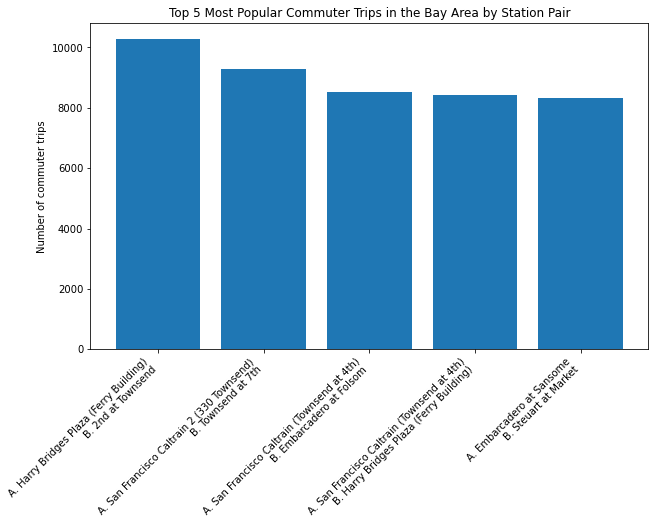

In [71]:
# Combine the names of the station pairs into strings to label the graph
top5_pairs = 'A. ' + df_top_trips['station1'][:5] + '\nB. ' + df_top_trips['station2'][:5]

# Plot the bar plot
plt.figure(figsize=(10,6))
plt.bar(top5_pairs, df_top_trips['total_trips'][:5])
plt.title("Top 5 Most Popular Commuter Trips in the Bay Area by Station Pair")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of commuter trips")
plt.show()

### What are your recommendations for offers?

After the "commuter trips" were identified, this subset of trips was further examined in order to pinpoint cases were ridership could be increased with different marketing offers to these riders. Based on this analysis, two recommendations for potential marketing offers were determined as listed below.

#### Recommendation 1: Offer discounted rides for "commuter trips" for new subscribers to a membership trial

The basis of this offer was discovered when investigating the availability of bikes at the popular stations during the hours of "commuter trips". To reiterate, the rides considered to be a "commuter trip" are any rides that occur between Monday-Friday, with the trip starting from anywtime between 7:00-9:59 or 16:00-18:59.

In the query below, a search is conducted for the average number of available bikes among the stations in top 10 most popular "commuter trips" that was displayed earlier in the notebook. The `station_status` table is joined with the top 10 most popular trips from the `commuter_trips` table in order to check the status of bike avaibility at these stations.

Within the top 10 most popular "commuter trips", there are 9 distinct stations, and the availability of bikes is broken out into the following subcategories per station:
- Commuter Trip Hours - Morning (average availability between 7:00-9:00)
- Commuter Trip Hours - Night (average availability between 16:00-18:00). 

In [1]:
 %%bigquery df_top10_bike_avail

SELECT station_id, start_station_name, 
    CASE
        WHEN (hour BETWEEN 7 AND 9) THEN 'Commuter Trip Hours - Morning'
        ELSE 'Commuter Trip Hours - Night'
    END AS trip_type,
    CAST(ROUND(AVG(bikes_available)) AS INT64) avg_bikes, 
FROM `w205-project-300900.bike_trip_data.station_status` AS stat
LEFT JOIN (
    WITH top10 AS(
        SELECT start_station_name, start_station_id, end_station_name, end_station_id, COUNT(trip_id) AS num_trips,
        FROM `w205-project-300900.bike_trip_data.commuter_trips`
        GROUP BY start_station_name, start_station_id, end_station_name, end_station_id
        ORDER BY num_trips DESC
        LIMIT 10)
    SELECT top10.start_station_name, top10.start_station_id FROM top10
    UNION DISTINCT
    SELECT top10.end_station_name, top10.end_station_id FROM top10) top10
ON stat.station_id = top10.start_station_id
WHERE station_id IN (top10.start_station_id)
    AND dow_str IN ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
    AND hour IN (7,8,9,16,17,18)
GROUP BY station_id, start_station_name, trip_type
ORDER BY station_id, trip_type;

In [2]:
df_top10_bike_avail

,station_id,start_station_name,trip_type,avg_bikes
0,50,Harry Bridges Plaza (Ferry Building),Commuter Trip Hours - Morning,11
1,50,Harry Bridges Plaza (Ferry Building),Commuter Trip Hours - Night,14
2,51,Embarcadero at Folsom,Commuter Trip Hours - Morning,8
3,51,Embarcadero at Folsom,Commuter Trip Hours - Night,7
4,55,Temporary Transbay Terminal (Howard at Beale),Commuter Trip Hours - Morning,9
5,55,Temporary Transbay Terminal (Howard at Beale),Commuter Trip Hours - Night,10
6,60,Embarcadero at Sansome,Commuter Trip Hours - Morning,6
7,60,Embarcadero at Sansome,Commuter Trip Hours - Night,6
8,61,2nd at Townsend,Commuter Trip Hours - Morning,12
9,61,2nd at Townsend,Commuter Trip Hours - Night,12


Using the table above, we can plot the average availability of bikes by morning hours and night hours for each station.

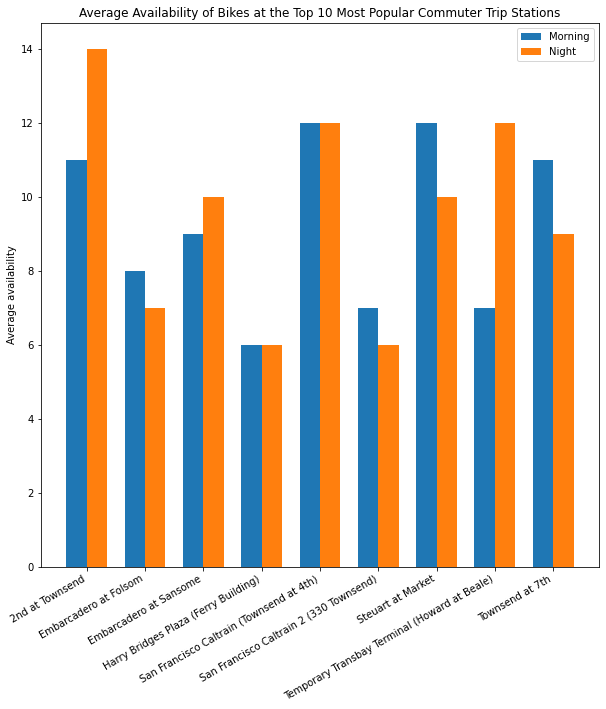

In [32]:
# Retrieve the station labels and the corresponding morning and night bike availability
stations = np.unique(df_top10_bike_avail['start_station_name'])
morning_avail = df_top10_bike_avail[df_top10_bike_avail['trip_type'] == 'Commuter Trip Hours - Morning']['avg_bikes']
night_avail = df_top10_bike_avail[df_top10_bike_avail['trip_type'] == 'Commuter Trip Hours - Night']['avg_bikes']

# Create bar locations and set the bar width
x = np.arange(len(stations))  
width = 0.35

# Create the bar plots
plt.figure(figsize=(10,10))
plt.bar(x-width/2, morning_avail, width, label='Morning')
plt.bar(x+width/2, night_avail, width, label='Night')

# Add the labels and legend
plt.title("Average Availability of Bikes at the Top 10 Most Popular Commuter Trip Stations")
plt.ylabel("Average availability")
plt.xticks(x, stations, rotation=30, ha='right')
plt.legend()

plt.show()

As can be seen from the chart above, it is clear that on average, many of the popular commuter stations still have a lot of bikes available and not in use during the "commuter trips" hours. Therefore, in order to take advantage of this surplus of bikes at stations which are common origin and destinations for these "commuter trips", it is recommended to offer discounted "commuter trip" rides for new subscribers to a limited period trial membership subscription. 

#### Recommandation 2: For new subscribers to the membership, allow them to have free weekend rentals for 3 months. This is good because there are more consumers on the weekend, so to encourage them to use the bikes more regularly during the week as well, include the free weekend deal.

### Appendix - Code for creating BigQuery views/tables

#### trip_dow_hour view

[Description]

```sql
SELECT trip_id, bike_number, 
    EXTRACT(DAYOFWEEK FROM start_date) AS start_dow_int,
    CASE EXTRACT(DAYOFWEEK FROM start_date)
        WHEN 1 THEN "Sunday"
        WHEN 2 THEN "Monday"
        WHEN 3 THEN "Tuesday"
        WHEN 4 THEN "Wednesday"
        WHEN 5 THEN "Thursday"
        WHEN 6 THEN "Friday"
        WHEN 7 THEN "Saturday"
        END AS start_dow_str,
    EXTRACT(HOUR FROM start_date) AS start_hour,
    
    EXTRACT(DAYOFWEEK FROM end_date) AS end_dow_int,
    CASE EXTRACT(DAYOFWEEK FROM end_date)
        WHEN 1 THEN "Sunday"
        WHEN 2 THEN "Monday"
        WHEN 3 THEN "Tuesday"
        WHEN 4 THEN "Wednesday"
        WHEN 5 THEN "Thursday"
        WHEN 6 THEN "Friday"
        WHEN 7 THEN "Saturday"
        END AS end_dow_str,
    EXTRACT(HOUR FROM end_date) AS end_hour,
    start_station_name, start_station_id, end_station_name, end_station_id,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY trip_id;
```

#### trips_with_regions view

[Description]

```sql 
SELECT trip_id, start_station_name, station_short_name, start_station_id, end_station_name, end_station_id, bike_number, region_id, region_name  FROM
(SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
INNER JOIN `bike_trip_data.station_region` ON start_station_id = station_id)
```

#### station_region view

[Description]

```sql 
SELECT station_id, short_name AS station_short_name, s.region_id, r.name AS region_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` s
INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_regions` r ON s.region_id = r.region_id
ORDER BY station_id;
```

#### commuter_trips view

[Description]

```sql
SELECT * FROM `w205-project-300900.bike_trip_data.trip_dow_hour` AS dow
LEFT JOIN(
    SELECT subscriber_type, trip_id 
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`) AS trips
USING(trip_id)
WHERE start_dow_str IN ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday') 
AND start_hour IN (7, 8, 9, 16, 17, 18);
```

#### station_status

[Description]

```sql 
SELECT station_id, bikes_available, docks_available,
    EXTRACT(DAYOFWEEK FROM time) AS dow_int,
    CASE EXTRACT(DAYOFWEEK FROM time)
        WHEN 1 THEN "Sunday"
        WHEN 2 THEN "Monday"
        WHEN 3 THEN "Tuesday"
        WHEN 4 THEN "Wednesday"
        WHEN 5 THEN "Thursday"
        WHEN 6 THEN "Friday"
        WHEN 7 THEN "Saturday"
        END AS dow_str,
    EXTRACT(HOUR FROM time) AS hour,
FROM `bigquery-public-data.san_francisco.bikeshare_status`
WHERE bikes_available > 0 OR docks_available > 0
ORDER BY station_id, dow_int;
```